In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.library import ZGate
from qiskit.circuit import ControlledGate
from qiskit.result import marginal_counts
from qiskit.visualization import plot_state_city

from qiskit_aer import Aer

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def calc_partition(
        total_qubits: int, 
        qubits_qpu: int, 
        max_qpus: int, 
        verbosity: int = 1
    ) -> list[int]:
    """ Calculates optimal partition of QPUs
    Input parameters:
    - total_qubits: int -> number of qubits to split across the QPUs
    - qubits_qpu: int -> number of qubits that the QPUs have
    - max_qpus: int -> maximum number of QPUs
    - verbosity: int -> level of verbosity
    """

    # Check that simulation has enough computation qubits, otherwise fail
    if max_qpus * qubits_qpu < total_qubits:
        raise ValueError(
            f"Cannot satisfy {total_qubits} in {max_qpus} QPUs of {qubits_qpu} qubits/QPU")

    # Calculate number of nodes needed, up to max_qpus
    num_nodes = int(np.ceil(total_qubits/qubits_qpu))

    # Ensure the router needed is not larger than the number of nodes, otherwise raise error
    if num_nodes > qubits_qpu:
        raise ValueError(f"Router requires {num_nodes} qubits -> larger than QPUs")

    qubits_left = total_qubits
    node_qubits = [0]*num_nodes
    for i in range(num_nodes - 1):
        node_qubits[i] = qubits_qpu
        qubits_left -= qubits_qpu

    node_qubits[num_nodes - 1] = qubits_left

    if verbosity >= 1:
        print(f"{num_nodes} nodes required with {node_qubits} computation qubits/node");

    return node_qubits

def define_registers(
        node_qubits: list[int]
    ) -> QuantumCircuit:
    """ Creates a QuantumCircuit with a quantum and classical register per node
    and for the router
    """

    qc = QuantumCircuit()

    # Add registers for nodes
    for i, n in enumerate(node_qubits):
        qc.add_register(QuantumRegister(size=n + 1, name=f"N{i}"))
        qc.add_register(ClassicalRegister(size=n + 1, name=f"n{i}"))

    # Add registers for router
    qc.add_register(QuantumRegister(size=len(node_qubits), name='R'))
    qc.add_register(ClassicalRegister(size=len(node_qubits), name='r'))    

    return qc

def MCZ(
        n_qubits: int
    ) -> ControlledGate:
    # Variable size MCZ gate, if n_qubits==1 applies Z gate

    if n_qubits == 1:
        return ZGate()
    else:
        return ZGate().control(n_qubits - 1)

def distMCZ(
        node_qubits: list[int]
    ) -> QuantumCircuit:
    """ Collective CC··Z where each of the nodes shares one ebit with router
    """

    qc = define_registers(node_qubits)

    node_qregs = qc.qregs[:-1]
    node_cregs = qc.cregs[:-1]
    router_qreg = qc.qregs[-1]
    router_creg = qc.cregs[-1]

    for (qreg, creg, EPR_router) in zip(node_qregs, node_cregs, router_qreg):
        EPR_user = qreg[-1]
        meas_user = creg[-1]

        # Generate EPR
        qc.h(EPR_user)
        qc.cx(EPR_user, EPR_router)
        qc.h(EPR_router)

        # Entangle local qubits in each node using MCZ gate
        qc.append(MCZ(qreg.size), qreg[:])

        # Measure EPR_user in X basis, and apply first corrections
        qc.h(EPR_user)
        qc.measure(EPR_user, meas_user)
        qc.x(EPR_user).c_if(meas_user, 1)
        qc.x(EPR_router).c_if(meas_user, 1)

    # Apply distributed gate
    qc.append(MCZ(router_qreg.size), router_qreg[:])

    for (qreg, EPR_router, meas_router) in zip(node_qregs, router_qreg, router_creg):
        # Measure EPR_router in X basis and apply second correction
        qc.h(EPR_router)
        qc.measure(EPR_router, meas_router)
        qc.x(EPR_router).c_if(meas_router, 1)
        qc.append(MCZ(qreg.size - 1).c_if(meas_router, 1), qreg[:-1])
    return qc

def GroverLayer(
        node_qubits: list[int],
        target: str
    ) -> QuantumCircuit:
    """ Add a single layer of Grover's oracle using distMCZ
    """

    qc = define_registers(node_qubits)

    # Extract computation qubits excluding router and communication qubits
    comp_qubits = []
    for node in qc.qregs[:-1]:
        comp_qubits += [q for q in node[:-1]]

    # Assert that Qubit and target are of the same length, otherwise fail
    assert len(comp_qubits) == len(target)

    for (q, t) in zip(comp_qubits, target):
        if not (t == '1'):
            qc.x(q)  # Flips qubits to construct oracle according to target

    qc = qc&distMCZ(node_qubits)

    for (q, t) in zip(comp_qubits, target):
        if not (t == '1'):
            qc.x(q)  # Undo bit flips according to target

    # Change basis between diffuser and oracle
    for q in comp_qubits:
        qc.h(q)

    qc = qc&distMCZ(node_qubits)

    # Change basis between diffuser and oracle
    for q in comp_qubits:
        qc.h(q)

    return qc

def Grover(
        target: str,
        comp_qubits_node: int,
        max_nodes: int, 
        num_layers: int = 0,
        save_state: bool = False,
        verbosity: int = 0
    ) -> tuple[QuantumCircuit, list[int]]:
    """
    This program will split and run Grover's search algorithm into multiple small-size QPUs
    using quantum communications to perform collective quantum gates between the QPUs.
    The program will automatically partition the collective gates into the smallest number of
    QPUs minimizing the number of ebits.

    Input parameters:
     - target: bitstring to build oracle. Length defines number of computation qubits
     - comp_qubits_node: number of computation qubits per QPU
     - max_nodes: number of QPUs the algorithm can use at most. It fails if more are required
     - num_layers: execute a specific number of Grover layers, if 0 optimal
     - save_state (DEBUG): saves density matrix
     - verbosity (DEBUG): level of verbosity (0: minimal, 1: standard)

    Output:
     - qc: QuantumCircuit of the whole algorithm
     - data_qubits: indices of the computation qubits
    """

    num_qubits = len(target)    

    # If num_layers == 0, calculate optimal
    if not num_layers:
        num_layers = int(np.floor(np.pi/4*np.sqrt(2**num_qubits) - 0.5))

    # Calculate the lowest ebit cost partition of the algorithm for the input parameters
    node_qubits = calc_partition(num_qubits, comp_qubits_node, max_nodes, verbosity)

    # Init qiskit QuantumCircuit
    qc = define_registers(node_qubits)

    # Save indices of computation qubits
    data_qubits = [i for i in range(node_qubits[0])]
    for node in node_qubits[1:]:  # Exclude first node
        data_qubits += [data_qubits[-1] + 2 + i for i in range(node)]

    if verbosity >= 1:
        QUBITS_SIMULATION = sum([q.size for q in qc.qregs])
        print(f"Number of layers: {num_layers}")
        print(f"Running distributed Grover's search algorithm with {num_layers} layers")
        print(f"Length of bitstring: {len(target)}");
        print(f"Total number of qubits (inc. comm. qubits): {QUBITS_SIMULATION}");

    # Initialise state to |->^(n)
    for qreg in qc.qregs[:-1]:
        for qubit in qreg[:-1]:
            qc.x(qubit)
            qc.h(qubit)

    # Define QuantumCircuit for Grover layer
    qc_layer = GroverLayer(node_qubits, target)

    # Add Grover layers
    qc.barrier()
    for i in range(num_layers):
        qc = qc&qc_layer
        qc.barrier()

    # Save density matrix
    if save_state:
        qc.save_density_matrix(
            qubits=data_qubits,
            label=r"$\rho$",
            conditional=False)

    # Measure qubits
    for qreg, creg in zip(qc.qregs[:-1], qc.cregs[:-1]):
        for qubit, result in zip(qreg[:-1], creg[:-1]):
            qc.measure(qubit, result)

    return qc, data_qubits

3 nodes required with [3, 3, 1] computation qubits/node
Number of layers: 4
Running distributed Grover's search algorithm with 4 layers
Length of bitstring: 7
Total number of qubits (inc. comm. qubits): 13


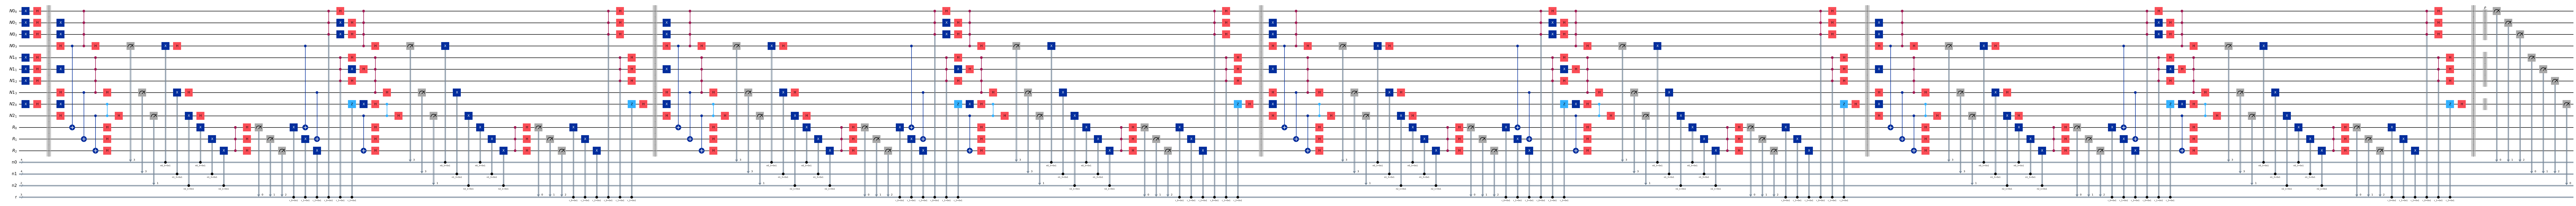

<IPython.core.display.Latex object>

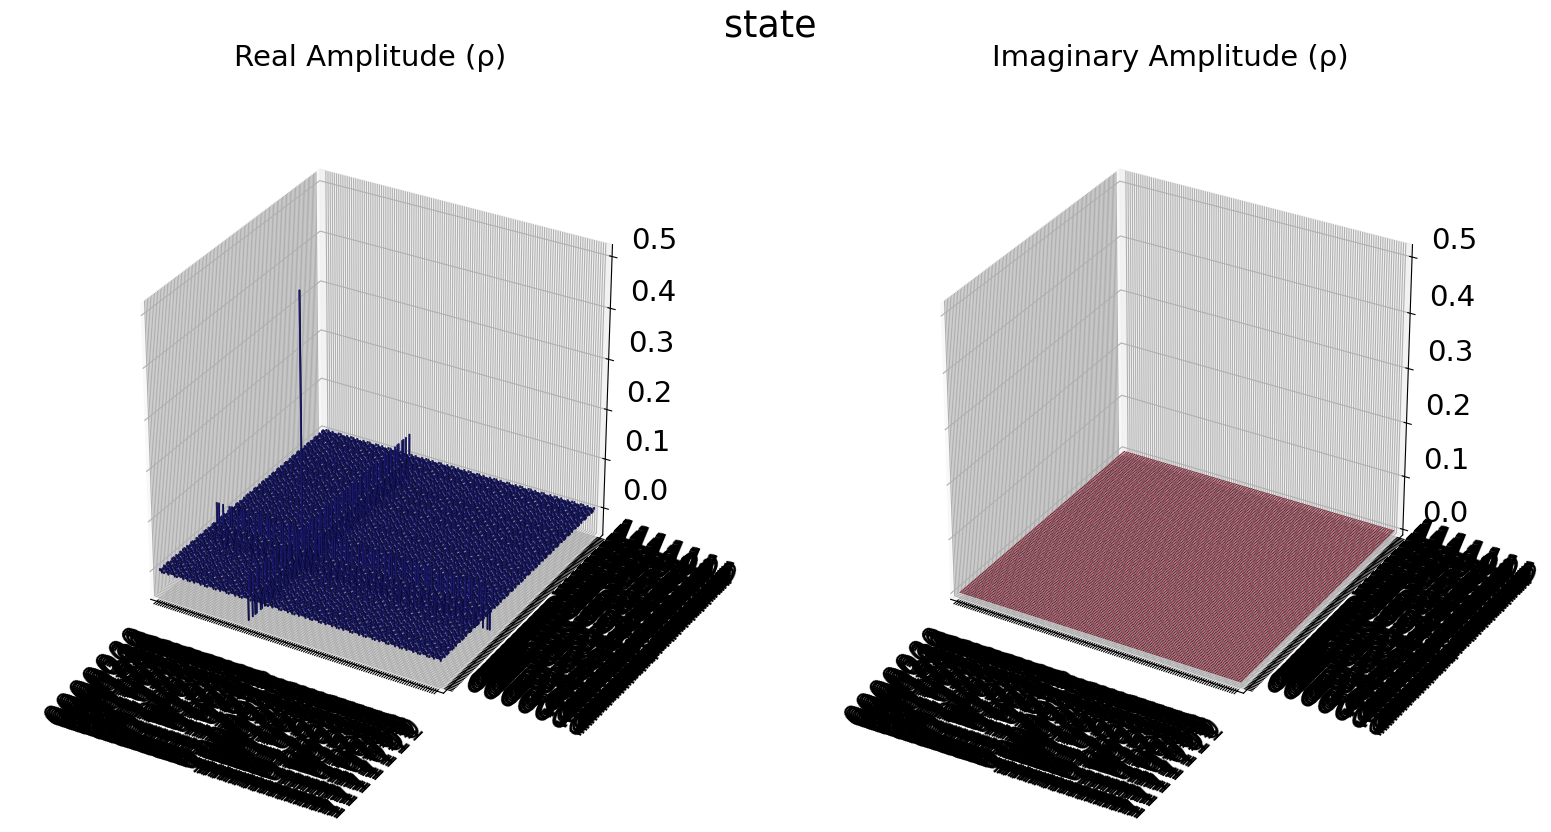

Most frequent string: 1001010 with 533/1000 (53.3 %)


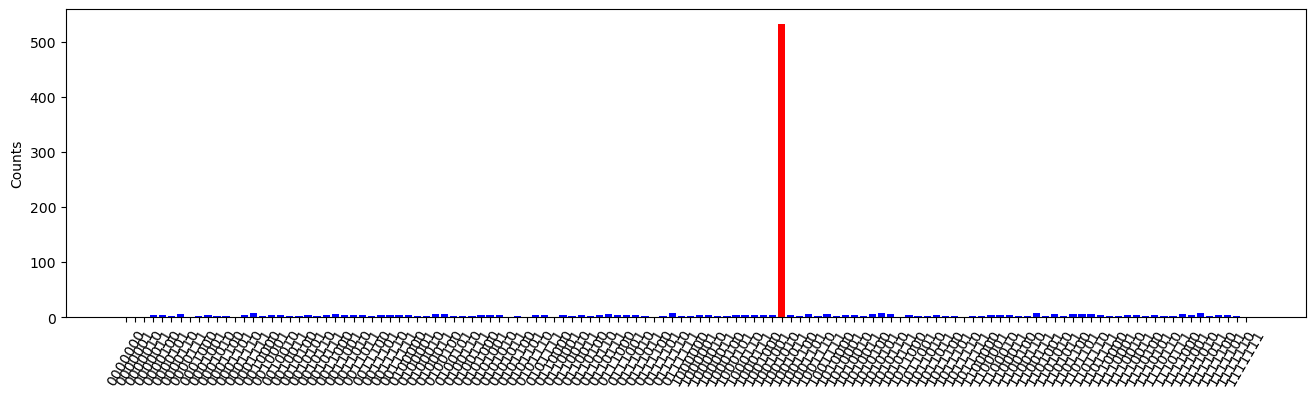

In [3]:
comp_qubits_node, max_nodes = 3, 5
target = "1001010"
num_qubits = len(target)
num_layers = 4  # 0 for optimal number of layers
save_state = True
plot_circuit = True
verbosity = 1
shots = 1000

qc, data_qubits = Grover(
    target,
    comp_qubits_node,
    max_nodes, 
    num_layers=num_layers,
    save_state=save_state,
    verbosity=verbosity
    )

if plot_circuit:
    display(qc.draw("mpl", fold=False))

if save_state:
    backend = Aer.get_backend("statevector_simulator")

    # Run distributed simulation
    job = backend.run(transpile(qc, backend), shots=1)
    result = job.result()
    state = result.data()[r"$\rho$"]

    display(
        state.draw("latex"),
        plot_state_city(state, color=['midnightblue', 'crimson'], title="state")
    )


# Simulate shots and plot histogram
backend = Aer.get_backend('aer_simulator')
result = backend.run(transpile(qc, backend), shots=shots).result()

# Only keep the counts of the relevant data qubits
counts = marginal_counts(result, data_qubits).get_counts()

reorder_counts = dict()
for k in counts:
    reorder_counts[k[::-1].replace(' ', '')] = counts[k]

scounts= dict(sorted(reorder_counts.items()))

maxkey = max(scounts, key=scounts.get)
maxval = scounts[maxkey]

print(f"Most frequent string: {maxkey} with {maxval}/{shots} ({100*maxval/shots} %)" )

fig, ax = plt.subplots(figsize=(16,4))
ax.set_ylabel("Counts")

# Mark target state
colors = ["red" if k == target else "blue" for k in scounts]

ax.bar(scounts.keys(), scounts.values(), color=colors)
ax.set_xticks(range(len(scounts.keys())), scounts.keys(), rotation=60)
plt.show()
